# Setup

In [1]:
import pandas as pd
import numpy as np

import os

from datetime import datetime
import time

import seaborn as sns
import matplotlib.pyplot as plt

import statistics as st
from math import cos, pi

from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

from keras.models import Sequential
from keras.layers import LSTM, Dense

import warnings
warnings.filterwarnings('ignore')

2023-05-31 08:28:53.585490: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-31 08:28:54.611124: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Read data

In [42]:
#df = pd.read_csv('train.csv')
test_data = pd.read_csv('test_public.csv')
#df_cleaned = pd.read_csv('train_cleaned.csv')

# if os.path.exists('dftrain.csv'):
#     dftrain = pd.read_csv('dftrain.csv')
# if os.path.exists('dftest.csv'):
#     dftest = pd.read_csv('dftest.csv')

In [27]:
print(df.shape)#, df_cleaned.shape)

(1710670, 9)


In [28]:
df.head(3)

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."


In [29]:
df.dtypes

TRIP_ID           int64
CALL_TYPE        object
ORIGIN_CALL     float64
ORIGIN_STAND    float64
TAXI_ID           int64
TIMESTAMP         int64
DAY_TYPE         object
MISSING_DATA       bool
POLYLINE         object
dtype: object

In [30]:
df.DAY_TYPE.unique()

array(['A'], dtype=object)

In [31]:
del df['DAY_TYPE']

In [10]:
df.CALL_TYPE.unique()

array(['C', 'B', 'A'], dtype=object)

In [11]:
df.describe()

,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP
count,1.710670e+06,364770.000000,806579.000000,1.710670e+06,1.710670e+06
mean,1.388622e+18,24490.363018,30.272381,2.000035e+07,1.388622e+09
std,9.180944e+15,19624.290043,17.747840,2.112405e+02,9.180944e+06
min,1.372637e+18,2001.000000,1.000000,2.000000e+07,1.372637e+09
25%,1.380731e+18,6593.000000,15.000000,2.000017e+07,1.380731e+09
50%,1.388493e+18,18755.000000,27.000000,2.000034e+07,1.388493e+09
75%,1.396750e+18,40808.000000,49.000000,2.000052e+07,1.396750e+09
max,1.404173e+18,63884.000000,63.000000,2.000098e+07,1.404173e+09


In [32]:
times = df.POLYLINE.apply(lambda x: max((x.count('[')-1-1)*15, 0)) # if (x.count('[')-1-1)*15 > 0 else np.nan)
df = df.assign(TRAVEL_TIME = times)

In [33]:
df = df[df.MISSING_DATA!=True]#.head(2)

In [8]:
df[df.TAXI_ID == 20000454].TRAVEL_TIME.mean()

614.9077216801019

In [5]:
curr_df = df_cleaned[['TRIP_ID', 'TAXI_ID', 'CALL_TYPE', 'ORIGIN_CALL', 'ORIGIN_STAND',
                      'TIMESTAMP', 'YR', 'MON', 'DAY', 'HR', 'WK', 'POLYLINE', 'LEN']]

In [93]:
"""[LON, LAT]"""
def get_lon_1st(x):
    if x == '[]':
        lon_1st = 0
    else:
        lon_1st = float(x[2:].split(',')[0])
    return lon_1st

def get_lat_1st(x):
    if x == '[]':
        last_1st = 0
    else:
        tmp = x[2:].split(',')[1]
        if tmp[-1] == ',':
            last_1st = float(tmp[:-1])
        else:
            last_1st = float(tmp[:-2])
    return last_1st

def get_lon_last(x):
    if x == '[]':
        lon_last = 0
    else:
        lon_last = float(x[2:].split('[')[-1].split(',')[0])
    return lon_last

def get_lat_last(x):
    if x == '[]':
        lat_last = 0
    else:
        lat_last = float(x[:-2].split(',')[-1])
    return lat_last

In [94]:
LON_1ST = curr_df.POLYLINE.apply(get_lon_1st)
LON_LAST = curr_df.POLYLINE.apply(get_lon_last)
LAT_1ST = curr_df.POLYLINE.apply(get_lat_1st)
LAT_LAST = curr_df.POLYLINE.apply(get_lat_last)

In [113]:
curr_df['LON_1ST'] = LON_1ST
curr_df['LON_LAST'] = LON_LAST
curr_df['LAT_1ST'] = LAT_1ST
curr_df['LAT_LAST'] = LAT_LAST

In [114]:
curr_df['DELTA_LON'] = LON_LAST - LON_1ST
curr_df['DELTA_LAT'] = LAT_LAST - LAT_1ST

In [122]:
curr_df

,TRIP_ID,TAXI_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TIMESTAMP,YR,MON,DAY,HR,WK,POLYLINE,LEN,LON_1ST,LON_LAST,LAT_1ST,LAT_LAST,DELTA_LON,DELTA_LAT
0,1372636858620000589,20000589,C,NaN,NaN,1372636858,2013,7,1,0,0,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",330,-8.618643,-8.630838,41.14141,41.154489,-0.012195,0.013079
1,1372637303620000596,20000596,B,NaN,7.0,1372637303,2013,7,1,0,0,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",270,-8.639847,-8.665740,41.15982,41.170671,-0.025893,0.010851
2,1372636951620000320,20000320,C,NaN,NaN,1372636951,2013,7,1,0,0,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",960,-8.612964,-8.615970,41.14035,41.140530,-0.003006,0.000180
3,1372636854620000520,20000520,C,NaN,NaN,1372636854,2013,7,1,0,0,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",630,-8.574678,-8.607996,41.15195,41.142915,-0.033318,-0.009035
4,1372637091620000337,20000337,C,NaN,NaN,1372637091,2013,7,1,0,0,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",420,-8.645994,-8.687268,41.18040,41.178087,-0.041274,-0.002313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710655,1404171463620000698,20000698,C,NaN,NaN,1404171463,2014,6,30,23,0,"[[-8.612469,41.14602],[-8.612487,41.145993],[-...",465,-8.612469,-8.611344,41.14600,41.171013,0.001125,0.025013
1710656,1404171367620000670,20000670,C,NaN,NaN,1404171367,2014,6,30,23,0,"[[-8.610138,41.140845],[-8.610174,41.140935],[...",435,-8.610138,-8.627454,41.14084,41.158755,-0.017316,0.017915
1710657,1388745716620000264,20000264,C,NaN,NaN,1388745716,2014,1,3,10,4,[],0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
1710658,1404141826620000248,20000248,B,NaN,12.0,1404141826,2014,6,30,15,0,"[[-8.630712,41.154885],[-8.63073,41.154813],[-...",915,-8.630712,-8.587026,41.15488,41.173524,0.043686,0.018644


In [121]:
curr_df.groupby('CALL_TYPE').max()

,TRIP_ID,TAXI_ID,ORIGIN_CALL,ORIGIN_STAND,TIMESTAMP,YR,MON,DAY,HR,WK,POLYLINE,LEN,LON_1ST,LON_LAST,LAT_1ST,LAT_LAST,DELTA_LON,DELTA_LAT
CALL_TYPE,,,,,,,,,,,,,,,,,,
A,1404172718620000066,20000941,63884.0,NaN,1404172718,2014,12,31,23,6,[],34845,0.000000,0.000000,47.397816,47.397816,1.135836,3.332410
B,1404172754620000518,20000904,NaN,63.0,1404172754,2014,12,31,23,6,[],57525,0.000000,0.000000,45.657220,44.119224,3.573621,2.973124
C,1404172796620000657,20000981,NaN,NaN,1404172796,2014,12,31,23,6,[],58200,52.900803,52.900803,51.037110,45.029601,3.170331,3.970235


In [120]:
test_data[test_data.TRIP_ID=='T230']

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA
222,T230,A,2002.0,NaN,20000434,1412612095,A,False


In [12]:
df.shape

(1710660, 9)

# Model 0
- Naive Decision Tree

In [9]:
dfsmall = df[['TAXI_ID', 'CALL_TYPE', 'TRAVEL_TIME']]

In [10]:
dfsmall = dfsmall.dropna()

In [11]:
dfsmall.tail()

,TAXI_ID,CALL_TYPE,TRAVEL_TIME
1710665,20000698,C,465
1710666,20000670,C,435
1710667,20000264,C,0
1710668,20000248,B,915
1710669,20000079,B,390


In [12]:
uniq_taxi_ids = dfsmall.TAXI_ID.unique()

In [27]:
mean_time_by_taxi_id = dfsmall.groupby('TAXI_ID')['TRAVEL_TIME'].mean() 
mean_time_by_call_type = dfsmall.groupby('CALL_TYPE')['TRAVEL_TIME'].mean() # .max()/10 gives really bad preds

In [28]:
ids = ['TRIP_ID']
preds = ['TRAVEL_TIME']
for i in dftest.iterrows():
    out_id = i[1]['TRIP_ID']
    taxi_id = i[1]['TAXI_ID']
    if taxi_id in uniq_taxi_ids:
        time = round(mean_time_by_taxi_id[taxi_id],0)
    else:
        call_type = i[1]['CALL_TYPE']
        time = round(mean_time_by_call_type[call_type],0)
    ids.append(out_id)
    preds.append(time)
    #print(time)

In [22]:
def save_preds(preds):
    file1 = open("pred.csv", "w")
    n = len(ids)
    for i in range(n):
        if i+1 != n:
            line = '"' + ids[i] + '",' + str(preds[i]) + '\n'
        else:
            line = '"' + ids[i] + '",'  + str(preds[i])
        file1.write(line)
    file1.close()

In [24]:
# save_preds(preds)

# Extract some more data

In [12]:
if os.path.exists('dftrain.csv'):
    dftrain = pd.read_csv('dftrain.csv')
if os.path.exists('dftest.csv'):
    dftest = pd.read_csv('dftest.csv')

In [26]:
##### if those files don't exist, use the following codes #####

In [13]:
def extract_time(data):
    datetime_timestamp = data.TIMESTAMP.apply(lambda x: datetime.fromtimestamp(x))
    years = datetime_timestamp.apply(lambda x: x.year)
    months = datetime_timestamp.apply(lambda x: x.month)
    weeks = datetime_timestamp.apply(lambda x: x.week) # week of year
    days = datetime_timestamp.apply(lambda x: x.day) # day of month
    hours = datetime_timestamp.apply(lambda x: x.hour) # hour of day
    mins = datetime_timestamp.apply(lambda x: x.minute) # minute of hour
    weekdays = datetime_timestamp.apply(lambda x: x.weekday()) # Monday=0
    
    df_out = data[["TRIP_ID", "TAXI_ID"]]

    df_out = df_out.assign(
        YEAR = years,
        MONTH = months,
        WEEK = weeks,
        DAY = days,
        HOUR = hours,
        MIN = mins,
        WEEKDAY = weekdays
    )
    
    return df_out

In [34]:
%%time
dftrain = extract_time(df)

CPU times: user 23.3 s, sys: 2.26 s, total: 25.6 s
Wall time: 25.5 s


In [43]:
%%time
dftest = extract_time(test_data)

CPU times: user 10.4 ms, sys: 3.07 ms, total: 13.4 ms
Wall time: 11 ms


In [15]:
def encode_call_type(in_df, data):
    typeA = data.CALL_TYPE.apply(lambda x: 1 if x == "A" else 0)
    typeB = data.CALL_TYPE.apply(lambda x: 1 if x == "B" else 0)
    typeC = data.CALL_TYPE.apply(lambda x: 1 if x == "C" else 0)
    in_df = in_df.assign(CALL_TYPE_A=typeA, CALL_TYPE_B=typeB, CALL_TYPE_C=typeC)
    return in_df

In [36]:
%%time
dftrain=encode_call_type(dftrain, df)

CPU times: user 1.51 s, sys: 172 ms, total: 1.68 s
Wall time: 1.68 s


In [44]:
%%time
dftest=encode_call_type(dftest, test_data)

CPU times: user 5.34 ms, sys: 719 µs, total: 6.06 ms
Wall time: 4.95 ms


In [17]:
def get_boolean(in_df, data):
    origin_call = data.ORIGIN_CALL.apply(lambda x: 1 if x is not None else 0)
    origin_stand = data.ORIGIN_STAND.apply(lambda x: 1 if x is not None else 0)
    missing_data = data.MISSING_DATA.apply(lambda x: 1 if x else 0)
    in_df = in_df.assign(ORIGIN_CALL=origin_call, 
                         ORIGIN_STAND=origin_stand, 
                         MISSING_DATA=missing_data)
    return in_df

In [37]:
%%time
dftrain = get_boolean(dftrain, df)

CPU times: user 1.49 s, sys: 191 ms, total: 1.69 s
Wall time: 1.68 s


In [45]:
%%time
dftest = get_boolean(dftest, test_data)

CPU times: user 5.82 ms, sys: 3.98 ms, total: 9.8 ms
Wall time: 7.8 ms


In [38]:
dftrain=dftrain.assign(TRAVEL_TIME=df.TRAVEL_TIME, TIMESTAMP=df.TIMESTAMP)

### clean empty rows ###
dftrain.dropna(inplace=True)

In [39]:
dftrain.head(3)

,TRIP_ID,TAXI_ID,YEAR,MONTH,WEEK,DAY,HOUR,MIN,WEEKDAY,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,ORIGIN_CALL,ORIGIN_STAND,MISSING_DATA,TRAVEL_TIME,TIMESTAMP
0,1372636858620000589,20000589,2013,7,27,1,0,0,0,0,0,1,1,1,0,330,1372636858
1,1372637303620000596,20000596,2013,7,27,1,0,8,0,0,1,0,1,1,0,270,1372637303
2,1372636951620000320,20000320,2013,7,27,1,0,2,0,0,0,1,1,1,0,960,1372636951


In [48]:
dftest=dftest.assign(TIMESTAMP=test_data.TIMESTAMP)
dftest.head(3)

,TRIP_ID,TAXI_ID,YEAR,MONTH,WEEK,DAY,HOUR,MIN,WEEKDAY,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,ORIGIN_CALL,ORIGIN_STAND,MISSING_DATA,TIMESTAMP
0,T1,20000542,2014,8,33,14,17,57,3,0,1,0,1,1,0,1408039037
1,T2,20000108,2014,8,33,14,17,50,3,0,1,0,1,1,0,1408038611
2,T3,20000370,2014,8,33,14,17,49,3,0,1,0,1,1,0,1408038568


In [50]:
#save_file = True 
if save_file:
    #dftrain.to_csv('dftrain.csv', index=False)
    dftest.to_csv('dftest.csv', index=False)

# EDA

### 1/.

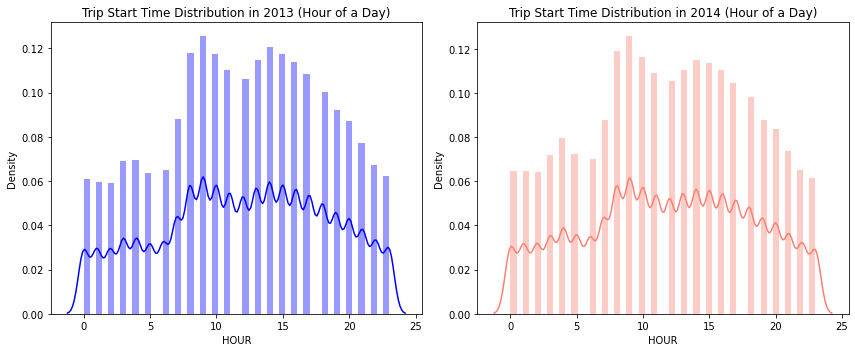

In [42]:
years = [2013,2014]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
axs = axs.flatten()

colors=['blue', 'salmon']
i = 0
for year in years:
    data = dftrain[dftrain.YEAR == year]
    sns.distplot(data.HOUR, ax=axs[i], color=colors[i])
    axs[i].set_title(f'Trip Start Time Distribution in {year} (Hour of a Day)')
    i += 1

plt.tight_layout()
plt.show()

### 2/.

In [44]:
hour = 0
hour_df = dftrain[dftrain.HOUR==0][['TRAVEL_TIME']]

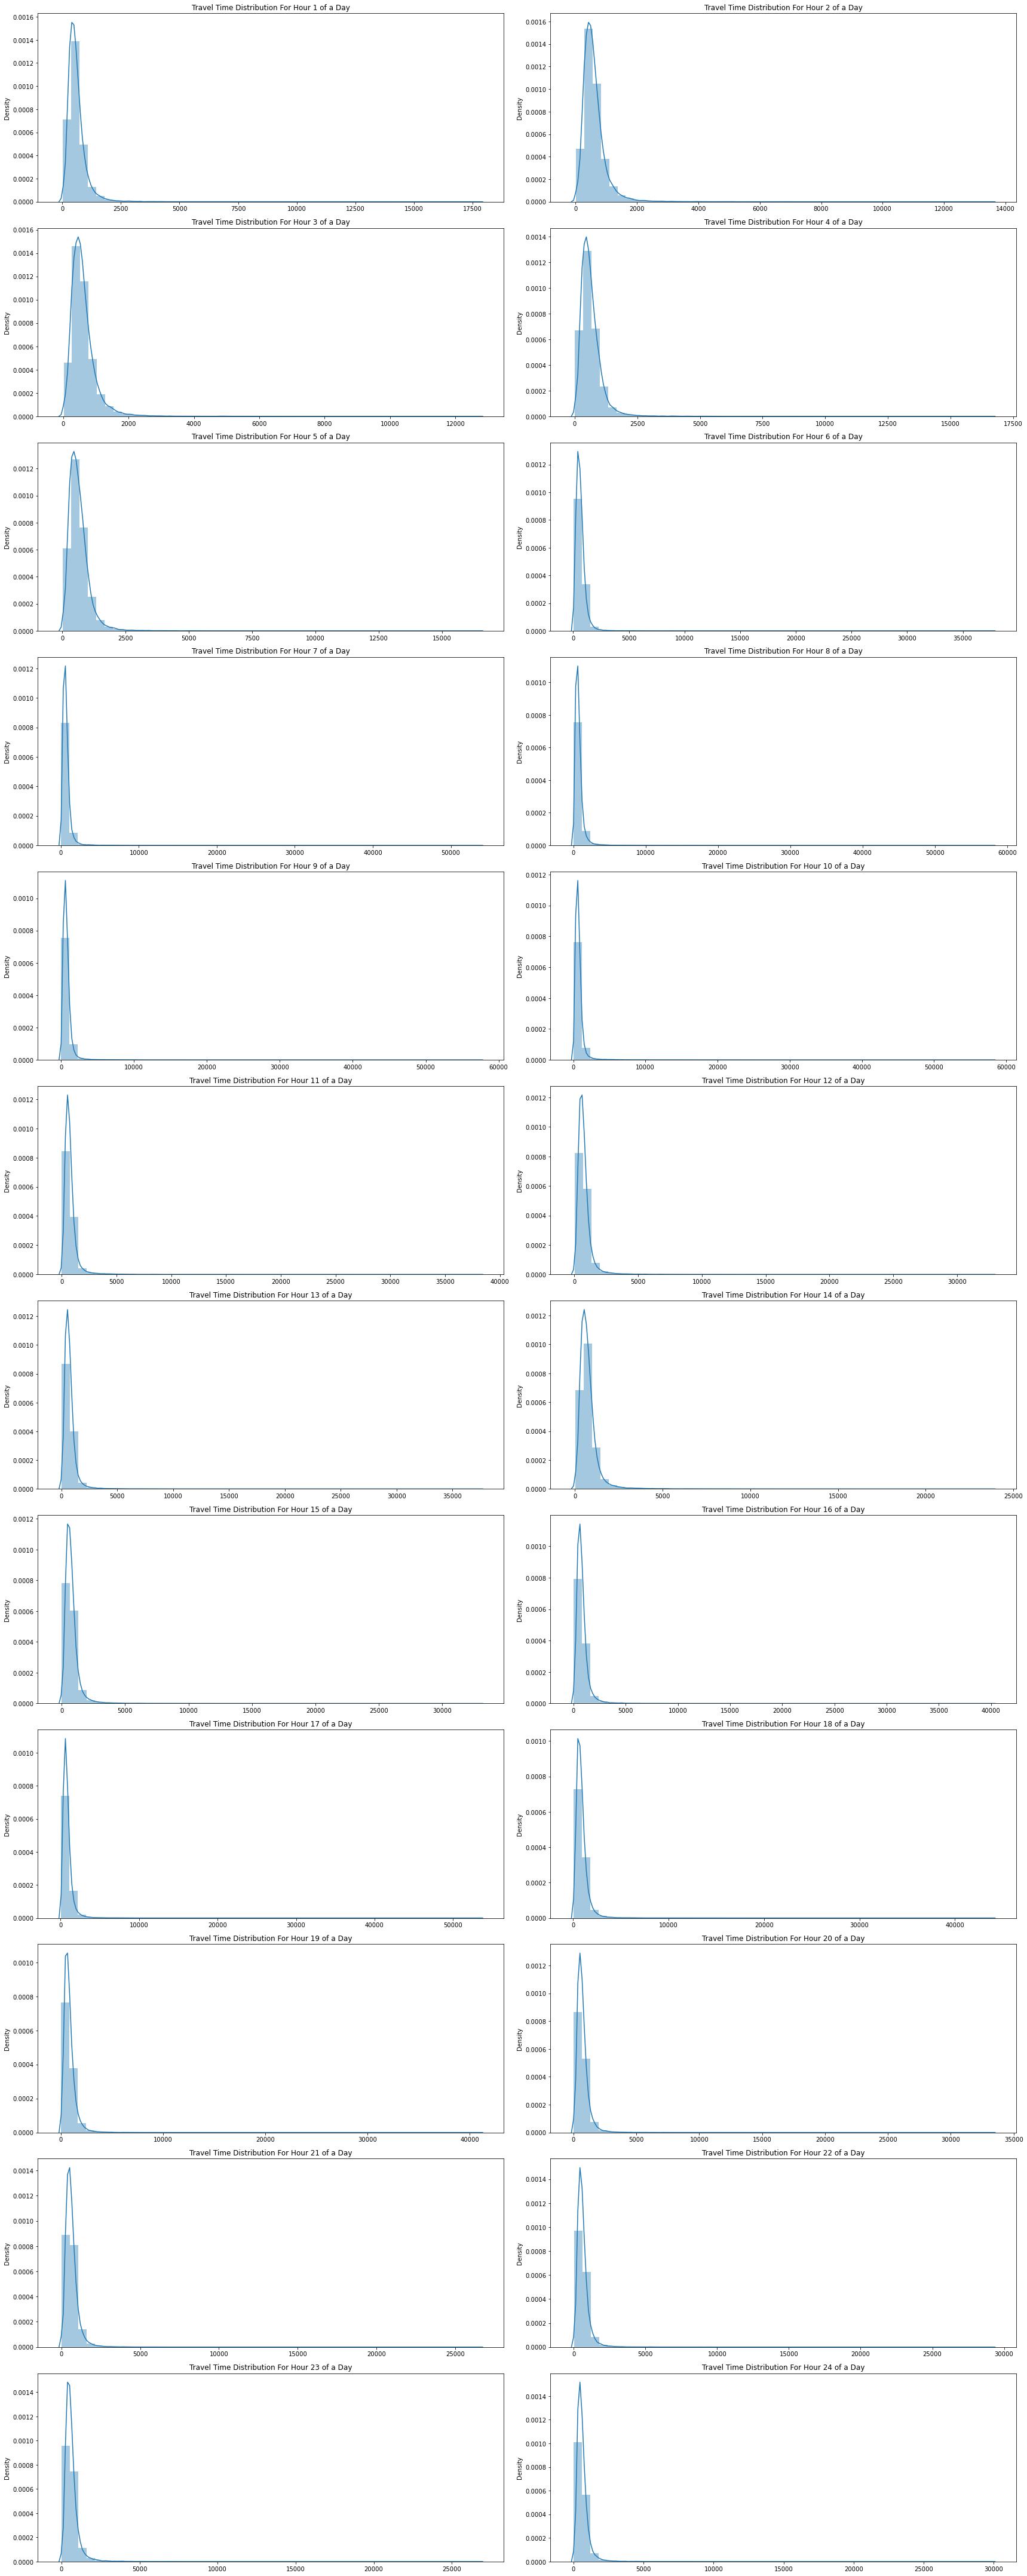

In [45]:
hours = range(24)

fig, axs = plt.subplots(nrows=12, ncols=2, figsize=(24,60))
axs = axs.flatten()

for i, hour in enumerate(hours):
    hour_df = dftrain[dftrain.HOUR==hour][['TRAVEL_TIME']]
    sns.distplot(hour_df, ax=axs[i])
    axs[i].set_title(f'Travel Time Distribution For Hour {hour+1} of a Day')

plt.tight_layout()
plt.show()

### 3/. 

<AxesSubplot:xlabel='TRAVEL_TIME'>

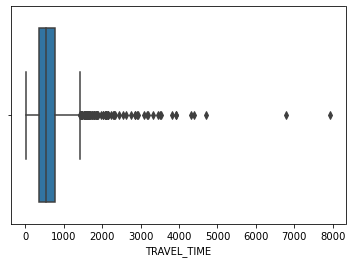

In [85]:
tmp_df = dftrain[(dftrain.CALL_TYPE_B==0) & (dftrain.HOUR==0) & (dftrain.WEEKDAY==0)][['TRAVEL_TIME']]
sns.boxplot(tmp_df['TRAVEL_TIME'])

In [90]:
times = dftrain['TRAVEL_TIME']
times.head()

0    330.0
1    270.0
2    960.0
3    630.0
4    420.0
Name: TRAVEL_TIME, dtype: float64

<AxesSubplot:xlabel='TRAVEL_TIME'>

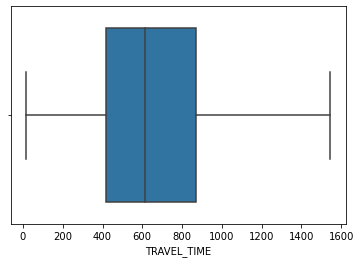

In [93]:
sns.boxplot(times, showfliers=False)

### 4/.

In [49]:
tmp_time15sec = df[df['TRAVEL_TIME']==15].groupby('CALL_TYPE').count()
# tmp_time15sec.

In [50]:
dftrain.groupby('CALL_TYPE_A').count()

,TRIP_ID,TAXI_ID,YEAR,MONTH,WEEK,DAY,HOUR,MIN,WEEKDAY,CALL_TYPE_B,CALL_TYPE_C,ORIGIN_CALL,ORIGIN_STAND,MISSING_DATA,TRAVEL_TIME
CALL_TYPE_A,,,,,,,,,,,,,,,
0,1311443,1311443,1311443,1311443,1311443,1311443,1311443,1311443,1311443,1311443,1311443,1311443,1311443,1311443,1311443
1,362717,362717,362717,362717,362717,362717,362717,362717,362717,362717,362717,362717,362717,362717,362717


In [51]:
dftrain.groupby('CALL_TYPE_B').count()

,TRIP_ID,TAXI_ID,YEAR,MONTH,WEEK,DAY,HOUR,MIN,WEEKDAY,CALL_TYPE_A,CALL_TYPE_C,ORIGIN_CALL,ORIGIN_STAND,MISSING_DATA,TRAVEL_TIME
CALL_TYPE_B,,,,,,,,,,,,,,,
0,865269,865269,865269,865269,865269,865269,865269,865269,865269,865269,865269,865269,865269,865269,865269
1,808891,808891,808891,808891,808891,808891,808891,808891,808891,808891,808891,808891,808891,808891,808891


In [52]:
weekday=0
weekdays=['Mon','Tue','Wed','Thur','Fri','Sat','Sun']
for hour in range(24):
    for yr in [2013,2014]:
        tmp = dftrain[(dftrain.CALL_TYPE_B==1) & (dftrain.YEAR==yr) & (dftrain.HOUR==hour) & (dftrain.WEEKDAY==weekday)]['TRAVEL_TIME']
        print("call type B,", "yr=", yr, ",hr=",str(hour), ", weekday=", weekdays[weekday])
        print("min=",min(tmp),", max=",max(tmp),", median=",statistics.median(tmp), ", mode=",statistics.mode(tmp), '\n')

call type B, yr= 2013 ,hr= 0 , weekday= Mon
min= 45.0 , max= 3900.0 , median= 495.0 , mode= 270.0 

call type B, yr= 2014 ,hr= 0 , weekday= Mon
min= 15.0 , max= 4665.0 , median= 480.0 , mode= 330.0 

call type B, yr= 2013 ,hr= 1 , weekday= Mon
min= 30.0 , max= 2835.0 , median= 465.0 , mode= 300.0 

call type B, yr= 2014 ,hr= 1 , weekday= Mon
min= 15.0 , max= 4935.0 , median= 480.0 , mode= 255.0 

call type B, yr= 2013 ,hr= 2 , weekday= Mon
min= 15.0 , max= 12690.0 , median= 480.0 , mode= 495.0 

call type B, yr= 2014 ,hr= 2 , weekday= Mon
min= 15.0 , max= 5880.0 , median= 525.0 , mode= 420.0 

call type B, yr= 2013 ,hr= 3 , weekday= Mon
min= 15.0 , max= 3450.0 , median= 465.0 , mode= 300.0 

call type B, yr= 2014 ,hr= 3 , weekday= Mon
min= 15.0 , max= 3840.0 , median= 540.0 , mode= 570.0 

call type B, yr= 2013 ,hr= 4 , weekday= Mon
min= 15.0 , max= 3675.0 , median= 525.0 , mode= 345.0 

call type B, yr= 2014 ,hr= 4 , weekday= Mon
min= 15.0 , max= 2625.0 , median= 540.0 , mode= 300.0 


In [53]:
weekday=0
weekdays=['Mon','Tue','Wed','Thur','Fri','Sat','Sun']
for hour in range(24):
    for yr in [2013,2014]:
        tmp = dftrain[(dftrain.CALL_TYPE_A==1) & (dftrain.YEAR==yr) & (dftrain.HOUR==hour) & (dftrain.WEEKDAY==weekday)]['TRAVEL_TIME']
        print("call type A,", "yr=", yr, ",hr=",str(hour), ", weekday=", weekdays[weekday])
        print("min=",min(tmp),", max=",max(tmp),", median=",statistics.median(tmp), ", mode=",statistics.mode(tmp), '\n')

call type A, yr= 2013 ,hr= 0 , weekday= Mon
min= 15.0 , max= 6795.0 , median= 540.0 , mode= 630.0 

call type A, yr= 2014 ,hr= 0 , weekday= Mon
min= 30.0 , max= 4710.0 , median= 540.0 , mode= 495.0 

call type A, yr= 2013 ,hr= 1 , weekday= Mon
min= 75.0 , max= 3030.0 , median= 510.0 , mode= 480.0 

call type A, yr= 2014 ,hr= 1 , weekday= Mon
min= 45.0 , max= 2745.0 , median= 540.0 , mode= 315.0 

call type A, yr= 2013 ,hr= 2 , weekday= Mon
min= 45.0 , max= 5745.0 , median= 645.0 , mode= 315.0 

call type A, yr= 2014 ,hr= 2 , weekday= Mon
min= 30.0 , max= 6300.0 , median= 600.0 , mode= 600.0 

call type A, yr= 2013 ,hr= 3 , weekday= Mon
min= 45.0 , max= 2355.0 , median= 765.0 , mode= 855.0 

call type A, yr= 2014 ,hr= 3 , weekday= Mon
min= 30.0 , max= 3960.0 , median= 772.5 , mode= 960.0 

call type A, yr= 2013 ,hr= 4 , weekday= Mon
min= 15.0 , max= 5310.0 , median= 750.0 , mode= 870.0 

call type A, yr= 2014 ,hr= 4 , weekday= Mon
min= 15.0 , max= 4560.0 , median= 750.0 , mode= 720.0 



In [69]:
taxi_ids=list(set(test_data['TAXI_ID']))

### Taxi_id == 20000256

In [55]:
test_data[test_data['TAXI_ID'] == taxi_ids[0]]

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA
73,T74,C,NaN,NaN,20000256,1408038045,A,False
245,T253,C,NaN,NaN,20000256,1414813121,A,False


<AxesSubplot:>

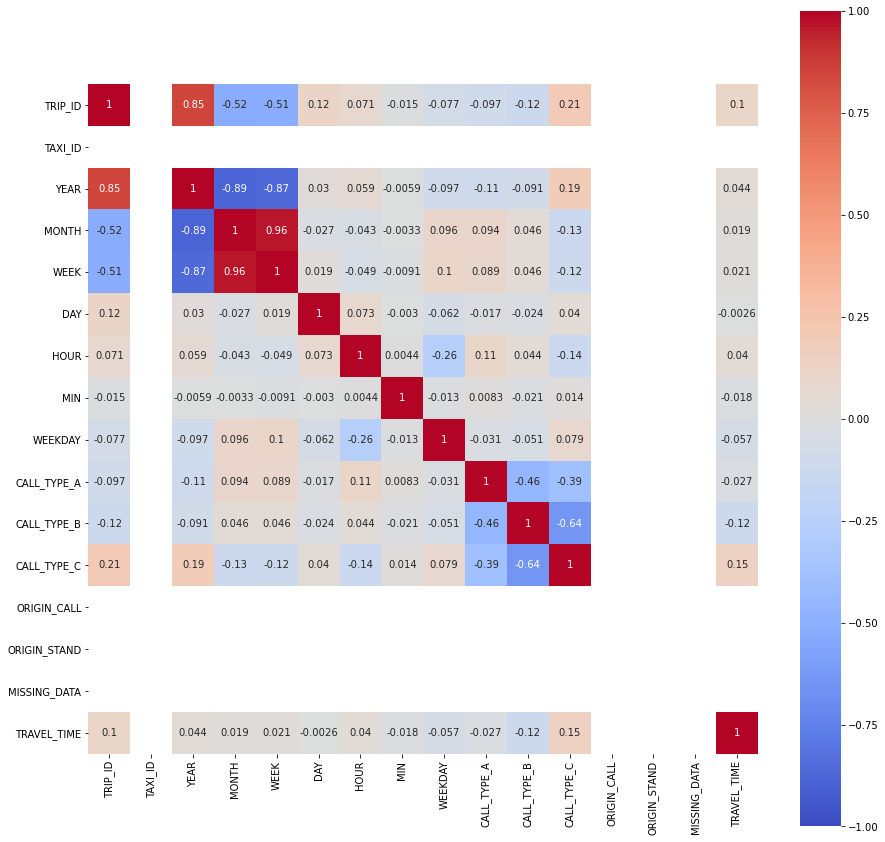

In [56]:
fig, ax = plt.subplots(figsize=(15,15))
new_train=dftrain[dftrain['TAXI_ID'] == taxi_ids[0]]
sns.heatmap(new_train.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm',square=True)

- For taxi_id == 20000256, travel time is correlated with
    - TRIP_ID: 0.1 (won't be useful b/c of masked trip_id in test set)
    - YEAR: 0.044 (should not include the year anyways b/c the test set only has the year=2014)
    - MONTH: 0.019
    - WEEK: 0.021
    - HOUR: 0.04
    - CALL_TYPE_C: 0.15 (for this particular id, only CALL_TYPE_C in the test set) -- seem like pushing the prediction a little too far from the previous predictions

In [57]:
%%time
Xtrain = []
ytrain = []

for row in new_train.iterrows():
    #year = row[1]['YEAR']
    hour = row[1]['HOUR']
    month = row[1]['MONTH']
    week = row[1]['WEEK']
    #call_typeC = row[1]['CALL_TYPE_C']
    Xtrain.append(np.array([hour,month,week]))
    ytrain.append(np.array([row[1]['TRAVEL_TIME']]))

CPU times: user 203 ms, sys: 4.81 ms, total: 208 ms
Wall time: 205 ms


In [ ]:
lr = LinearRegression(n_jobs=1)

# Fitting
lr = lr.fit(Xtrain, ytrain)

In [ ]:
tmp_test=dftest[dftest['TAXI_ID'] == taxi_ids[0]]

In [ ]:
%%time
Xtest = []

for row in tmp_test.iterrows():
    #year = row[1]['YEAR']
    hour = row[1]['HOUR']
    month = row[1]['MONTH']
    week = row[1]['WEEK']
    #call_typeC = row[1]['CALL_TYPE_C']
    Xtest.append(np.array([hour,month,week]))

In [ ]:
lr.predict(Xtest) # T74: 844; T253: 777

### Taxi_id == 20000260

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
new_train=dftrain[dftrain['TAXI_ID'] == taxi_ids[1]]
sns.heatmap(new_train.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm',square=True)

- For taxi_id == 20000260, travel time is correlated with
    - TRIP_ID: 0.023 (won't be useful b/c of masked trip_id in test set)
    - MONTH: 0.044
    - WEEK: 0.044
    - DAY: 0.01
    - HOUR: 0.038
    - MIN: 0.019
    - CALL_TYPE_A: 0.0042
    - CALL_TYPE_C: 0.071 (for this particular id, only CALL_TYPE_C in the test set) -- seem like pushing the prediction a little too far from the previous predictions

In [ ]:
%%time
Xtrain = []
ytrain = []

for row in new_train.iterrows():
    #year = row[1]['YEAR']
    month = row[1]['MONTH']
    week = row[1]['WEEK']
    hour = row[1]['HOUR']
    mins = row[1]['MIN']
    day = row[1]['DAY']
    #call_typeC = row[1]['CALL_TYPE_C']
    Xtrain.append(np.array([month,week,hour,mins,day]))
    ytrain.append(np.array([row[1]['TRAVEL_TIME']]))

In [ ]:
lr = LinearRegression(n_jobs=1)

# Fitting
lr = lr.fit(Xtrain, ytrain)

In [ ]:
tmp_test=dftest[dftest['TAXI_ID'] == taxi_ids[1]]

Xtest = []

for row in tmp_test.iterrows():
    #year = row[1]['YEAR']
    month = row[1]['MONTH']
    week = row[1]['WEEK']
    hour = row[1]['HOUR']
    mins = row[1]['MIN']
    day = row[1]['DAY']
    #call_typeC = row[1]['CALL_TYPE_C']
    Xtest.append(np.array([month,week,hour,mins,day]))

In [ ]:
lr.predict(Xtest) # T68: 641, T128: 628

In [ ]:
tmp_test

### CURRENT MODEL: Correlation heatmap at scale

In [ ]:
ROUND_NUMBER = False
trips_id = []
travel_preds = []

for taxi_id in taxi_ids:
    new_train=dftrain[dftrain['TAXI_ID'] == taxi_id]
    
    train_corr=new_train[['TRAVEL_TIME', 'YEAR', 'MONTH', 'WEEK', 'DAY', 'HOUR', 'MIN', 'WEEKDAY']].corr()
    positive_corr_list=list(train_corr[train_corr > 0]['TRAVEL_TIME'].dropna().keys())
    positive_corr_list.remove('TRAVEL_TIME')
    
    Xtrain = []
    ytrain = []

    for row in new_train.iterrows():
        lst = []
        for elem in positive_corr_list:
            lst.append(row[1][elem])

        Xtrain.append(np.array(lst))
        ytrain.append(np.array([row[1]['TRAVEL_TIME']]))
    
    lr = LinearRegression(n_jobs=1)
    lr = lr.fit(Xtrain, ytrain)
    
    tmp_test=dftest[dftest['TAXI_ID'] == taxi_id]
    for row in tmp_test.iterrows():
        trip_id = row[1]['TRIP_ID']
        
        lst = []
        for elem in positive_corr_list:
            lst.append(row[1][elem])
            
        #Reshape your data either using array.reshape(-1, 1) if your data has a single feature 
        #or array.reshape(1, -1) if it contains a single sample.
        pred = lr.predict(np.array(lst).reshape(1,-1))[0][0]
        if ROUND_NUMBER:
            if pred - int(pred) <0.5:
                pred = int(pred)+1
            else:
                pred = int(pred)
        travel_preds.append(pred)
        trips_id.append(trip_id)

In [ ]:
len(trips_id)

In [ ]:
dcts=dict(zip(trips_id, travel_preds))

In [ ]:
train_corr[train_corr > 0]['TRAVEL_TIME'].dropna()

In [ ]:
#additional_model = pd.read_csv('outputs/DT2_LR1_over3_pred.csv')

In [ ]:
#additional_model_ids = list(additional_model.TRIP_ID)

In [ ]:
# available_dcts = list(dcts.keys())
# for trip in additional_model_ids:
#     if trip not in available_dcts:
#         dcts[trip] = additional_model[additional_model['TRIP_ID'] == trip].reset_index()['TRAVEL_TIME'][0]

In [ ]:
# trips=['TRIP_ID']
# travels=['"TRAVEL_TIME"']

# for trip in additional_model_ids:
#     travel=dcts[trip]
#     trips.append(trip)
#     travels.append(travel)

In [ ]:
all_ids = list(test_data.TRIP_ID)

In [ ]:
dcts=dict(zip(trips_id, travel_preds))

all_ids = list(test_data.TRIP_ID)

file1 = open("pred.csv", "w")
n = len(trips_id)
line='"TRIP_ID","TRAVEL_TIME"\n'
file1.write(line)
for i in range(n):
    if i+1 != n:
        line = '"' + all_ids[i] + '",' + str(dcts[all_ids[i]]) + '\n'
    else:
        line = '"' + all_ids[i] + '",'  + str(dcts[all_ids[i]])
    file1.write(line)
file1.close()

## Gradient Boosting
- so bad

In [ ]:
trips_id = []
travel_preds = []

for taxi_id in taxi_ids:
    new_train=dftrain[dftrain['TAXI_ID'] == taxi_id]
    
    train_corr=new_train[['TRAVEL_TIME', 'YEAR', 'MONTH', 'WEEK', 'DAY', 'HOUR', 'MIN', 'WEEKDAY']].corr()
    positive_corr_list=list(train_corr[train_corr > 0]['TRAVEL_TIME'].dropna().keys())
    positive_corr_list.remove('TRAVEL_TIME')
    
    Xtrain = []
    ytrain = []

    for row in new_train.iterrows():
        lst = []
        for elem in positive_corr_list:
            lst.append(row[1][elem])

        Xtrain.append(np.array(lst))
        ytrain.append(np.array([row[1]['TRAVEL_TIME']]))
    
    model = GradientBoostingRegressor(random_state=0)
    model = model.fit(Xtrain, ytrain)
    
    tmp_test=dftest[dftest['TAXI_ID'] == taxi_id]
    for row in tmp_test.iterrows():
        trip_id = row[1]['TRIP_ID']
        
        lst = []
        for elem in positive_corr_list:
            lst.append(row[1][elem])
            
        #Reshape your data either using array.reshape(-1, 1) if your data has a single feature 
        #or array.reshape(1, -1) if it contains a single sample.
        pred = model.predict(np.array(lst).reshape(1,-1))[0]
#         if pred - int(pred) <0.5:
#             pred = int(pred)+1
#         else:
#             pred = int(pred)
        travel_preds.append(pred)
        trips_id.append(trip_id)

In [ ]:
dcts=dict(zip(trips_id, travel_preds))

In [ ]:
all_ids = list(test_data.TRIP_ID)
file1 = open("pred.csv", "w")
n = len(trips_id)
line='"TRIP_ID","TRAVEL_TIME"\n'
file1.write(line)
for i in range(n):
    if i+1 != n:
        line = '"' + all_ids[i] + '",' + str(dcts[all_ids[i]]) + '\n'
    else:
        line = '"' + all_ids[i] + '",'  + str(dcts[all_ids[i]])
    file1.write(line)
file1.close()

## Math Model

In [ ]:
import statistics

In [ ]:
model = pd.read_csv('outputs/DT2_LR1_over3_pred.csv')

ROUND_NUMBER = True
trips_id = []
travel_preds = []

for taxi_id in taxi_ids:
    new_train=dftrain[dftrain['TAXI_ID'] == taxi_id]
    new_train['Num Bracket'] = new_train['TRAVEL_TIME']/15+1
    tmp_test=dftest[dftest['TAXI_ID'] == taxi_id]
    
    for row in tmp_test.iterrows():
        trip_id = row[1]['TRIP_ID']
        call_type = 'CALL_TYPE_C'

        if row[1]['CALL_TYPE_A']:
            call_type = 'CALL_TYPE_A'
        elif row[1]['CALL_TYPE_B']:
            call_type = 'CALL_TYPE_B'
    
        pred = (np.median(new_train[(new_train['DAY'] == row[1]['DAY'])
                          &(new_train['WEEKDAY'] == row[1]['WEEKDAY'])
                          &(new_train[call_type] == 1)]['Num Bracket'])-15)*15 #7
        # may want to observe the brackets using model 0 and mode
        if np.isnan(pred) or pred < 0:
            #print('here')
            pred = model[model.TRIP_ID == trip_id].reset_index()['TRAVEL_TIME'][0]
        pred2 = model[model.TRIP_ID == trip_id].reset_index()['TRAVEL_TIME'][0]
        pred = (pred2+pred)/2
        #print(pred)
#         if pred < 0:
#             pred = 0
        travel_preds.append(pred)
        trips_id.append(trip_id)

In [ ]:
dcts=dict(zip(trips_id, travel_preds))

In [ ]:
len(dcts)

In [ ]:
all_ids = list(test_data.TRIP_ID)

file1 = open("test pred 151b.csv", "w")
n = len(trips_id)
line='"TRIP_ID","TRAVEL_TIME"\n'
file1.write(line)
for i in range(n):
    if i+1 != n:
        line = '"' + all_ids[i] + '",' + str(dcts[all_ids[i]]) + '\n'
    else:
        line = '"' + all_ids[i] + '",'  + str(dcts[all_ids[i]])
    file1.write(line)
file1.close()

In [ ]:
pred_file = pd.read_csv('test pred 151b.csv')

In [ ]:
pred_file = pd.read_csv('test pred 151b.csv')
for i in pred_file['TRAVEL_TIME']:
    print(i)

In [ ]:
(np.median(new_train[(new_train['DAY'] == 14)
                      &(new_train['WEEKDAY'] == 3)
                      &(new_train['CALL_TYPE_B'] == 1)]['Num Bracket'])-1)*15

In [ ]:
dftest.ORIGIN_CALL.unique()

In [5]:
dftest[dftest['TAXI_ID'] == 20000542]

,TRIP_ID,TAXI_ID,YEAR,MONTH,WEEK,DAY,HOUR,MIN,WEEKDAY,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,ORIGIN_CALL,ORIGIN_STAND,MISSING_DATA
0,T1,20000542,2014,8,33,14,17,57,3,0,1,0,1,1,0
300,T308,20000542,2014,12,51,21,11,41,6,0,0,1,1,1,0


In [7]:
new_train=dftrain[dftrain['TAXI_ID'] == 20000542]
new_train['Num Bracket'] = new_train['TRAVEL_TIME']/15+1

In [76]:
trips_id = []
travel_preds = []

for taxi_id in taxi_ids:
    new_train=dftrain[dftrain['TAXI_ID'] == taxi_id]
    train_corr=new_train[['TRAVEL_TIME', 'YEAR', 'MONTH', 'WEEK', 'DAY', 'HOUR', 'MIN', 'WEEKDAY']].corr()
    positive_corr_list=list(train_corr[train_corr > 0]['TRAVEL_TIME'].dropna().keys())
    positive_corr_list.remove('TRAVEL_TIME')

Xtrain = []
ytrain = []

for row in new_train.iterrows():
    lst = []
    for elem in positive_corr_list:
        lst.append(row[1][elem])

    Xtrain.append(np.array(lst))
    value = row[1]['TRAVEL_TIME'] #/ 15 + 1
    ytrain.append(np.array([value]))
    
    X_train = np.array(Xtrain)
    y_train = np.array(ytrain)

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    y_train = np.reshape(y_train, (-1,1))

    timesteps = X_train.shape[1]
    features = X_train.shape[2]
    num_classes = 1

    # Define the LSTM model
    model = Sequential()
    model.add(LSTM(128, input_shape=(timesteps, features)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_classes, activation='relu'))

    # Compile the model
    model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, epochs=10,verbose=False)#, validation_data=(X_val, y_val))
    
    tmp_test=dftest[dftest['TAXI_ID'] == taxi_id]  
    for row in tmp_test.iterrows():
        trip_id = row[1]['TRIP_ID']

        lst = []
        for elem in positive_corr_list:
            lst.append(row[1][elem])

        #Reshape your data either using array.reshape(-1, 1) if your data has a single feature 
        #or array.reshape(1, -1) if it contains a single sample.
        pred = model.predict(np.array(lst).reshape(1,-1))[0][0]
        print(trip_id,pred)
#         preds.append(pred)
        
#         travel_preds.append(pred)
#         trips_id.append(trip_id)

2023-05-26 06:01:08.796891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-26 06:01:08.799472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-26 06:01:08.801220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 541ms/step
T56 2.9000952
1/1 [==============================] - 0s 41ms/step
T327 3.0537903


2023-05-26 06:01:13.468293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-26 06:01:13.470727: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-26 06:01:13.472451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 533ms/step
T56 0.0
1/1 [==============================] - 0s 41ms/step
T327 0.0


2023-05-26 06:01:19.499633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-26 06:01:19.502001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-26 06:01:19.507021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 487ms/step


2023-05-26 06:01:23.921569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-26 06:01:23.924739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-26 06:01:23.926342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

T56 0.0
1/1 [==============================] - 0s 37ms/step
T327 0.0


2023-05-26 06:01:24.532925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-26 06:01:24.535432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-26 06:01:24.537543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 504ms/step
T56 0.0
1/1 [==============================] - 0s 30ms/step
T327 0.0


2023-05-26 06:01:29.171969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-26 06:01:29.174743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-26 06:01:29.176540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 514ms/step


2023-05-26 06:01:33.383500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-26 06:01:33.385776: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-26 06:01:33.387491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

T56 0.0
1/1 [==============================] - 0s 36ms/step
T327 0.0


2023-05-26 06:01:33.968493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-26 06:01:33.972838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-26 06:01:33.975512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 517ms/step
T56 3.0199192
1/1 [==============================] - 0s 35ms/step
T327 3.4091341


2023-05-26 06:01:38.833174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-26 06:01:38.835472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-26 06:01:38.837245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 538ms/step
T56 0.0
1/1 [==============================] - 0s 44ms/step
T327 0.0


2023-05-26 06:01:45.071076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-26 06:01:45.073556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-26 06:01:45.075341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 494ms/step


2023-05-26 06:01:49.237828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-26 06:01:49.240449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-26 06:01:49.242089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

T56 2.4613285
1/1 [==============================] - 0s 35ms/step
T327 2.7602994


2023-05-26 06:01:49.818385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-26 06:01:49.820738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-26 06:01:49.822409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 528ms/step
T56 2.6810052
1/1 [==============================] - 0s 33ms/step
T327 3.0620356


2023-05-26 06:01:54.531711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-26 06:01:54.534031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-26 06:01:54.535676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 486ms/step


2023-05-26 06:01:58.580197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-26 06:01:58.583125: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-26 06:01:58.584693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

T56 2.5852478
1/1 [==============================] - 0s 33ms/step
T327 2.799014


2023-05-26 06:01:59.167229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-26 06:01:59.169596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-26 06:01:59.171668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 474ms/step


2023-05-26 06:02:03.239512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-26 06:02:03.241601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-26 06:02:03.243149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

T56 3.2439015
1/1 [==============================] - 0s 35ms/step
T327 3.4864745


2023-05-26 06:02:03.817456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-26 06:02:03.819811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-26 06:02:03.821488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 2s 2s/step
T56 2.9792018
1/1 [==============================] - 0s 38ms/step
T327 3.285677


2023-05-26 06:02:09.924846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-26 06:02:09.927273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-26 06:02:09.929005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 515ms/step
T56 3.2117388
1/1 [==============================] - 0s 34ms/step
T327 3.518208


2023-05-26 06:02:14.672591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-26 06:02:14.675254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-26 06:02:14.677107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 471ms/step


2023-05-26 06:02:18.751997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-26 06:02:18.754270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-26 06:02:18.755833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

T56 3.5928428
1/1 [==============================] - 0s 32ms/step
T327 4.081944


2023-05-26 06:02:19.263669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-26 06:02:19.265664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-26 06:02:19.267168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 543ms/step
T56 0.0
1/1 [==============================] - 0s 34ms/step
T327 0.0


2023-05-26 06:02:24.019690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-26 06:02:24.021992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-26 06:02:24.023529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 511ms/step
T56 0.0
1/1 [==============================] - 0s 33ms/step
T327 0.0


2023-05-26 06:02:28.763901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-26 06:02:28.766130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-26 06:02:28.767834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 499ms/step


2023-05-26 06:02:32.767846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-26 06:02:32.770448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-26 06:02:32.772175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

T56 0.0
1/1 [==============================] - 0s 34ms/step
T327 0.0


2023-05-26 06:02:34.557791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-26 06:02:34.561121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-26 06:02:34.563035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

KeyError: 'gradient_tape/sequential_146/dense_564/MatMul/MatMul'

In [ ]:
dcts=dict(zip(trips_id, travel_preds))

In [ ]:
all_ids = list(test_data.TRIP_ID)

file1 = open("test pred 151b.csv", "w")
n = len(trips_id)
line='"TRIP_ID","TRAVEL_TIME"\n'
file1.write(line)
for i in range(n):
    if i+1 != n:
        line = '"' + all_ids[i] + '",' + str(dcts[all_ids[i]]) + '\n'
    else:
        line = '"' + all_ids[i] + '",'  + str(dcts[all_ids[i]])
    file1.write(line)
file1.close()


In [ ]:
pred_file = pd.read_csv('test pred 151b.csv')
for i in pred_file['TRAVEL_TIME']:
    print(i)

In [215]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

2023-05-28 01:49:07.457879: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-28 01:49:08.661022: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [92]:
test_data

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA
0,T1,B,NaN,15.0,20000542,1408039037,A,False
1,T2,B,NaN,57.0,20000108,1408038611,A,False
2,T3,B,NaN,15.0,20000370,1408038568,A,False
3,T4,B,NaN,53.0,20000492,1408039090,A,False
4,T5,B,NaN,18.0,20000621,1408039177,A,False
...,...,...,...,...,...,...,...,...
315,T323,A,70885.0,NaN,20000430,1419171485,A,False
316,T324,B,NaN,53.0,20000020,1419170802,A,False
317,T325,C,NaN,NaN,20000207,1419172121,A,False
318,T326,A,76232.0,NaN,20000667,1419171980,A,False


In [213]:
new_train=dftrain[dftrain['TAXI_ID'] == 20000492]

train_corr=new_train[['TRAVEL_TIME', 'YEAR', 'MONTH', 'WEEK', 'DAY', 'HOUR', 'MIN', 'WEEKDAY']].corr()
positive_corr_list=list(train_corr[train_corr > 0]['TRAVEL_TIME'].dropna().keys())
positive_corr_list.remove('TRAVEL_TIME')

Xtrain = []
ytrain = []

for row in new_train.iterrows():
    lst = []
    for elem in positive_corr_list:
        lst.append(row[1][elem])
 
    Xtrain.append(np.array(lst))
    ytrain.append(np.array([row[1]['TRAVEL_TIME']]))

In [217]:
X_train = np.array(Xtrain)
y_train = np.array(ytrain)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))


model = Sequential()

# Add input layer and first hidden layer
model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))

# Add additional hidden layers
#model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=16, activation='relu'))


# Add output layer
model.add(Dense(units=1, activation='relu'))

# Compile the model
model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=10)


# timesteps = X_train.shape[1]
# features = X_train.shape[2]
# num_classes = 1

# # Define the LSTM model
# model = Sequential()
# model.add(LSTM(128, input_shape=(timesteps, features)))
# model.add(Dense(num_classes, activation='relu'))

# # Compile the model
# model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])

# # Train the model
# model.fit(X_train, y_train, epochs=10, verbose=True)#, validation_data=(X_val, y_val))

Epoch 1/10


2023-05-28 01:49:37.019398: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:219] failed to create cublas handle: the library was not initialized
2023-05-28 01:49:37.019472: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:222] Failure to initialize cublas may be due to OOM (cublas needs some free memory when you initialize it, and your deep-learning framework may have preallocated more than its fair share), or may be because this binary was not built with support for the GPU in your machine.
2023-05-28 01:49:37.019536: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at matmul_op_impl.h:621 : INTERNAL: Attempting to perform BLAS operation using StreamExecutor without BLAS support
2023-05-28 01:49:37.019576: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:GPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: Attempting to perform BLAS oper

InternalError: Graph execution error:

Detected at node 'sequential_1/dense_5/MatMul' defined at (most recent call last):
    File "/opt/conda/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/conda/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/conda/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/conda/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/opt/conda/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
      self._run_once()
    File "/opt/conda/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
      handle._run()
    File "/opt/conda/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 390, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/opt/conda/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2898, in run_cell
      result = self._run_cell(
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2944, in _run_cell
      return runner(coro)
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3169, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3361, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_102/1018338752.py", line 26, in <module>
      model.fit(X_train, y_train, batch_size=32, epochs=10)
    File "/opt/conda/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "/opt/conda/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/opt/conda/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/opt/conda/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.9/site-packages/keras/layers/core/dense.py", line 241, in call
      outputs = tf.matmul(a=inputs, b=self.kernel)
Node: 'sequential_1/dense_5/MatMul'
Attempting to perform BLAS operation using StreamExecutor without BLAS support
	 [[{{node sequential_1/dense_5/MatMul}}]] [Op:__inference_train_function_2420]

In [ ]:
tmp_test=dftest[dftest['TAXI_ID'] == 20000492]
preds = []   
for row in tmp_test.iterrows():
    trip_id = row[1]['TRIP_ID']

    lst = []
    for elem in positive_corr_list:
        lst.append(row[1][elem])
    
    #Reshape your data either using array.reshape(-1, 1) if your data has a single feature 
    #or array.reshape(1, -1) if it contains a single sample.
    pred = model.predict(np.array(lst).reshape(1,-1))[0]
    preds.append(pred)

In [153]:
preds

[array([544.75397], dtype=float32), array([545.03217], dtype=float32)]

In [144]:
tmp_test

,TRIP_ID,TAXI_ID,YEAR,MONTH,WEEK,DAY,HOUR,MIN,WEEKDAY,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,ORIGIN_CALL,ORIGIN_STAND,MISSING_DATA
3,T4,20000492,2014,8,33,14,17,58,3,0,1,0,1,1,0
242,T250,20000492,2014,11,44,1,3,54,5,0,1,0,1,1,0


In [174]:
test_data[test_data['TRIP_ID']=='T327']

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA
319,T327,A,31208.0,NaN,20000255,1419171420,A,False


In [175]:
test_data[test_data['TAXI_ID']==20000255]

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA
55,T56,B,NaN,14.0,20000255,1408038850,A,False
319,T327,A,31208.0,NaN,20000255,1419171420,A,False


<AxesSubplot:>

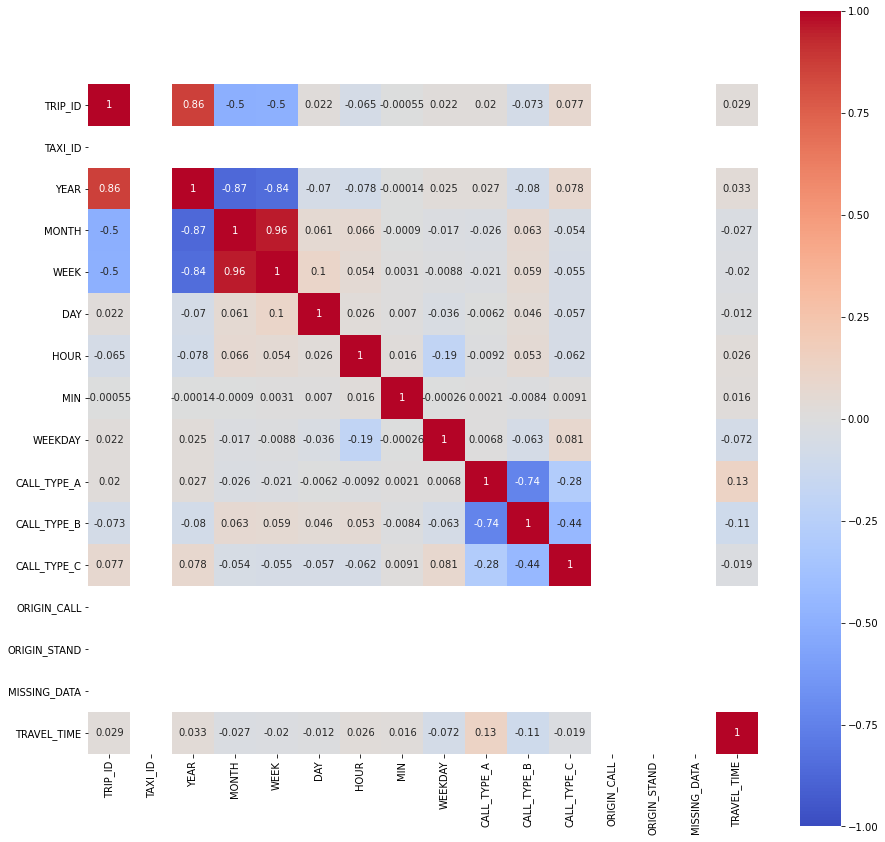

In [178]:
fig, ax = plt.subplots(figsize=(15,15))
dfsns=dftrain[dftrain['TAXI_ID'] == 20000255]
sns.heatmap(dfsns.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm',square=True)

In [180]:
np.mean(dftrain[dftrain.CALL_TYPE_A == 1]['TRAVEL_TIME'])

754.5849381198013

In [181]:
new_train=dftrain[dftrain['TAXI_ID'] == taxi_id]

train_corr=new_train[['TRAVEL_TIME', 'YEAR', 'MONTH', 'WEEK', 'DAY', 'HOUR', 'MIN', 'WEEKDAY', 
                      'CALL_TYPE_A', 'CALL_TYPE_B', 'CALL_TYPE_C']].corr()

In [192]:
train_corr[train_corr > 0]['TRAVEL_TIME'].dropna().drop('TRAVEL_TIME').idxmax()

'CALL_TYPE_A'

In [196]:
model = pd.read_csv('outputs/pred-Copy1.csv')

In [197]:
model

,TRIP_ID,TRAVEL_TIME
0,T1,475.00
1,T2,692.00
2,T3,459.00
3,T4,473.75
4,T5,551.50
...,...,...
315,T323,495.50
316,T324,457.50
317,T325,950.00
318,T326,669.00


In [198]:
trips_id = []
travel_preds = []

for taxi_id in taxi_ids:
    new_train=dftrain[dftrain['TAXI_ID'] == taxi_id]
    
    train_corr=new_train[['TRAVEL_TIME', 'YEAR', 'MONTH', 'WEEK', 'DAY', 'HOUR', 'MIN', 'WEEKDAY', 
                          'CALL_TYPE_A', 'CALL_TYPE_B', 'CALL_TYPE_C']].corr()
    max_ = train_corr[train_corr > 0]['TRAVEL_TIME'].dropna().drop('TRAVEL_TIME').idxmax()
    
    tmp_test=dftest[dftest['TAXI_ID'] == taxi_id]
    for row in tmp_test.iterrows():
        trip_id = row[1]['TRIP_ID']        
        if 'CALL_TYPE' not in max_:
            pred = model[model['TRIP_ID'] == trip_id].reset_index()['TRAVEL_TIME'][0]
        else:
            pred = np.mean(dftrain[dftrain[max_] == 1]['TRAVEL_TIME'])
        travel_preds.append(pred)
        trips_id.append(trip_id)

In [200]:
dcts=dict(zip(trips_id, travel_preds))

all_ids = list(test_data.TRIP_ID)

for i in all_ids:
    print(dcts[i])
# file1 = open("pred.csv", "w")
# n = len(trips_id)
# line='"TRIP_ID","TRAVEL_TIME"\n'
# file1.write(line)
# for i in range(n):
#     if i+1 != n:
#         line = '"' + all_ids[i] + '",' + str(dcts[all_ids[i]]) + '\n'
#     else:
#         line = '"' + all_ids[i] + '",'  + str(dcts[all_ids[i]])
#     file1.write(line)
# file1.close()

475.0
754.5849381198013
459.0
754.5849381198013
754.5849381198013
811.5289462582977
672.5664829995636
754.5849381198013
754.5849381198013
672.5664829995636
811.5289462582977
761.0
811.5289462582977
811.5289462582977
811.5289462582977
811.5289462582977
688.5
811.5289462582977
811.5289462582977
811.5289462582977
709.0
752.0
754.5849381198013
811.5289462582977
811.5289462582977
811.5289462582977
501.25
811.5289462582977
811.5289462582977
662.5
405.5
759.0
597.5
754.5849381198013
811.5289462582977
754.5849381198013
885.0
811.5289462582977
610.0
633.75
913.25
754.5849381198013
811.5289462582977
811.5289462582977
811.5289462582977
811.5289462582977
733.0
672.5664829995636
811.5289462582977
754.5849381198013
673.5
811.5289462582977
811.5289462582977
672.5664829995636
754.5849381198013
754.5849381198013
811.5289462582977
754.5849381198013
811.5289462582977
754.5849381198013
811.5289462582977
764.5
754.5849381198013
537.75
661.5
754.5849381198013
585.5
811.5289462582977
568.75
754.5849381198013

## More EDA (May 27, 2023)

In [184]:
trip_id = 'T6'
taxi_id = test_data[test_data['TRIP_ID'] == trip_id].reset_index()['TAXI_ID'][0]

In [186]:
t6 = dftrain[dftrain['TAXI_ID'] == taxi_id]

In [187]:
dftest[dftest['TAXI_ID'] == taxi_id]

,TRIP_ID,TAXI_ID,YEAR,MONTH,WEEK,DAY,HOUR,MIN,WEEKDAY,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,ORIGIN_CALL,ORIGIN_STAND,MISSING_DATA
5,T6,20000607,2014,8,33,14,17,25,3,1,0,0,1,1,0


In [204]:
x=np.percentile(t6[(t6.WEEKDAY==3) ]['TRAVEL_TIME'],89.5) #Y
x

2043.8999999999999

In [205]:
(2040-x)**2

15.209999999998935

In [208]:
np.mean([1,2])

1.5

In [212]:
for trip_id in test_data.TRIP_ID:
    taxi_id = test_data[test_data['TRIP_ID'] == trip_id].reset_index()['TAXI_ID'][0]
    t=dftrain[dftrain['TAXI_ID']==taxi_id]
    w=t[t.WEEK==dftest[dftest['TRIP_ID'] == trip_id].reset_index()['WEEK'][0]]
    wd=t[t.WEEKDAY==dftest[dftest['TRIP_ID'] == trip_id].reset_index()['WEEKDAY'][0]]
    p1=w['TRAVEL_TIME']
    p2=wd['TRAVEL_TIME']
    if p1.shape[0] == 0:
        if p2.shape[0] == 0:
            print(trip_id, 'both None')
        else:
            #print(trip_id, st.mode(p2))
            print(st.mode(p2))
    else:
        if p2.shape[0] == 0:
            print(st.mode(p1))
        else:
            pred=min(st.mode(p1),st.mode(p2))
            print(pred)

300.0
600.0
405.0
360.0
390.0
480.0
420.0
585.0
375.0
600.0
360.0
510.0
330.0
345.0
450.0
270.0
540.0
525.0
525.0
420.0
345.0
540.0
570.0
510.0
405.0
465.0
450.0
465.0
420.0
465.0
405.0
480.0
570.0
690.0
495.0
525.0
420.0
540.0
510.0
495.0
285.0
630.0
285.0
300.0
345.0
375.0
450.0
570.0
750.0
420.0
600.0
540.0
345.0
465.0
330.0
360.0
510.0
480.0
510.0
390.0
690.0
555.0
300.0
450.0
315.0
360.0
555.0
255.0
735.0
285.0
435.0
480.0
270.0
420.0
480.0
495.0
510.0
750.0
435.0
525.0
405.0
375.0
720.0
450.0
510.0
330.0
795.0
315.0
735.0
495.0
600.0
480.0
465.0
555.0
255.0
480.0
420.0
405.0
480.0
15.0
615.0
570.0
210.0
375.0
15.0
495.0
405.0
180.0
540.0
375.0
435.0
540.0
450.0
360.0
540.0
300.0
375.0
375.0
240.0
645.0
555.0
435.0
420.0
360.0
300.0
660.0
480.0
720.0
390.0
375.0
255.0
480.0
465.0
375.0
555.0
495.0
510.0
510.0
450.0
525.0
660.0
510.0
405.0
645.0
525.0
525.0
600.0
435.0
345.0
315.0
330.0
390.0
315.0
480.0
330.0
465.0
465.0
570.0
420.0
645.0
480.0
270.0
360.0
405.0
510.0
405.0
540.0


In [181]:
p2=wd['TRAVEL_TIME']
    if p1.shape[0] == 0:
        if p2.shape[0] == 0:
            print(trip_id, 'both None')
        else:
            #print(trip_id, st.mode(p2))
            print(np.percentile(p2,89.5))
    else:
        if p2.shape[0] == 0:
            print(np.percentile(p1,89.5))
        else:
            pred=np.mean([np.percentile(p1,89.5),np.percentile(p2,89.5)])
            print(pred)

,TRIP_ID,TAXI_ID,YEAR,MONTH,WEEK,DAY,HOUR,MIN,WEEKDAY,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,ORIGIN_CALL,ORIGIN_STAND,MISSING_DATA,TRAVEL_TIME
190027,1376301660620000108,20000108,2013,8,33,12,10,1,0,0,0,1,1,1,0,885.0
190433,1376303956620000108,20000108,2013,8,33,12,10,39,0,0,0,1,1,1,0,2745.0
190958,1376310077620000108,20000108,2013,8,33,12,12,21,0,0,1,0,1,1,0,480.0
191361,1376318733620000108,20000108,2013,8,33,12,14,45,0,0,0,1,1,1,0,2910.0
191433,1376324981620000108,20000108,2013,8,33,12,16,29,0,0,1,0,1,1,0,285.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216168,1376856816620000108,20000108,2013,8,33,18,20,13,6,0,0,1,1,1,0,255.0
216286,1376858639620000108,20000108,2013,8,33,18,20,43,6,0,0,1,1,1,0,900.0
216454,1376860816620000108,20000108,2013,8,33,18,21,20,6,0,0,1,1,1,0,1200.0
216529,1376864760620000108,20000108,2013,8,33,18,22,26,6,0,0,1,1,1,0,540.0


## More plots

<AxesSubplot:xlabel='TRAVEL_TIME'>

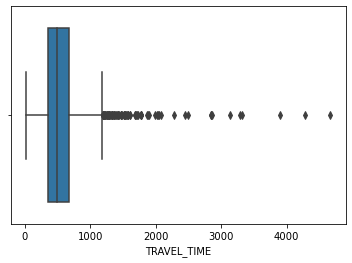

In [63]:
tmp_df = dftrain[(dftrain.CALL_TYPE_B==1) & (dftrain.HOUR==0) & (dftrain.WEEKDAY==0)][['TRAVEL_TIME']]
sns.boxplot(tmp_df['TRAVEL_TIME'])

<AxesSubplot:xlabel='TRAVEL_TIME'>

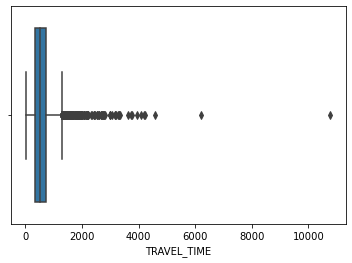

In [60]:
tmp_df = dftrain[(dftrain.HOUR==0) & (dftrain.WEEKDAY==1)][['TRAVEL_TIME']]
sns.boxplot(tmp_df['TRAVEL_TIME'])

# Models

## Some more setups

In [7]:
dftrain = pd.read_csv('dftrain.csv')
dftest = pd.read_csv('dftest.csv')

In [14]:
%%time
Xtrain = []
ytrain = []

gap = 100_000
start = 0
end = start + gap
df_end = dftrain.shape[0]
flag = False

while end < df_end:
    print('Process rows: start =', start, 'end =', end)
    tmp_dftrain = dftrain[start:end]
    
    for row in tmp_dftrain.iterrows():
        Xtrain.append(np.array(row[1])[2:-1])
        ytrain.append([np.array(row[1])[-1]])
    
    start = start + gap
    end = start + gap
    
    if end > df_end - 1:
        if not flag:
            end = df_end - 1
            flag = True

Process rows: start = 0 end = 100000
Process rows: start = 100000 end = 200000
Process rows: start = 200000 end = 300000
Process rows: start = 300000 end = 400000
Process rows: start = 400000 end = 500000
Process rows: start = 500000 end = 600000
Process rows: start = 600000 end = 700000
Process rows: start = 700000 end = 800000
Process rows: start = 800000 end = 900000
Process rows: start = 900000 end = 1000000
Process rows: start = 1000000 end = 1100000
Process rows: start = 1100000 end = 1200000
Process rows: start = 1200000 end = 1300000
Process rows: start = 1300000 end = 1400000
Process rows: start = 1400000 end = 1500000
Process rows: start = 1500000 end = 1600000
Process rows: start = 1600000 end = 1674159
CPU times: user 60 s, sys: 1.13 s, total: 1min 1s
Wall time: 1min


In [8]:
%%time
Xtest = []
for row in dftest.iterrows():
    Xtest.append(np.array(row[1])[2:])

CPU times: user 19.3 ms, sys: 1.01 ms, total: 20.3 ms
Wall time: 19.3 ms


In [33]:
def save_preds_2(prediction):
    ids = ['TRIP_ID']
    preds = ['"TRAVEL_TIME"']
    j = 0
    for i in dftest.iterrows():
        out_id = i[1]['TRIP_ID']
        taxi_id = i[1]['TAXI_ID']
        time = prediction[j][0]
        j += 1
        ids.append(out_id)
        preds.append(time)

    file1 = open("pred.csv", "w")
    n = len(ids)
    for i in range(n):
        if i+1 != n:
            line = '"' + ids[i] + '",' + str(preds[i]) + '\n'
        else:
            line = '"' + ids[i] + '",'  + str(preds[i])
        file1.write(line)
    file1.close()

## Model 1
- Linear Regression

In [17]:
# Model 1
lr = MultiOutputRegressor(LinearRegression(n_jobs=1))

# Fitting
lr = lr.fit(Xtrain[:500_000], ytrain[:500_000])
lr = lr.fit(Xtrain[500_000:], ytrain[500_000:])

In [18]:
# Predict
preds = lr.predict(Xtest)

/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


In [34]:
save_preds_2(preds)

## Model 2
- Random Forest

In [36]:
forest = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=1))

# Fitting
forest = forest.fit(Xtrain[:500_000], ytrain[:500_000])

In [37]:
forest = forest.fit(Xtrain[500_000:], ytrain[500_000:])

# Predict
preds = forest.predict(Xtest)

/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


In [38]:
save_preds_2(preds)

# Model 3
- Decision Tree + Random Forest

In [41]:
model0 = pd.read_csv('outputs/decision_tree_pred.csv')
model1 = pd.read_csv('outputs/linear_regression_pred.csv')

In [43]:
ids = ['TRIP_ID']
preds = ['"TRAVEL_TIME"']

for i in model0.iterrows():
    out_id = i[1]['TRIP_ID']
    time = int((model0[model0['TRIP_ID'] == out_id]['TRAVEL_TIME']
            +model1[model1['TRIP_ID'] == out_id]['TRAVEL_TIME'])/2)
    ids.append(out_id)
    preds.append(time)

In [44]:
save_preds(preds)

## Model 4

In [ ]:
model0 = pd.read_csv('outputs/decision_tree_pred.csv')
model1 = pd.read_csv('outputs/linear_regression_pred.csv')

In [45]:
ids = ['TRIP_ID']
preds = ['"TRAVEL_TIME"']

for i in model0.iterrows():
    out_id = i[1]['TRIP_ID']
    time = int((model0[model0['TRIP_ID'] == out_id]['TRAVEL_TIME']
            +model1[model1['TRIP_ID'] == out_id]['TRAVEL_TIME']*2)/3)
    ids.append(out_id)
    preds.append(time)

In [46]:
save_preds(preds)

## Model 5

In [ ]:
model0 = pd.read_csv('outputs/decision_tree_pred.csv')
model1 = pd.read_csv('outputs/linear_regression_pred.csv')

In [56]:
ids = ['TRIP_ID']
preds = ['"TRAVEL_TIME"']

j = 0
for i in model0.iterrows():
    out_id = i[1]['TRIP_ID']
    time = round((model0[model0['TRIP_ID'] == out_id]['TRAVEL_TIME']*2
            +model1[model1['TRIP_ID'] == out_id]['TRAVEL_TIME'])/3)[j]
    j += 1
    ids.append(out_id)
    preds.append(time)

In [57]:
save_preds(preds)

## Model 6

In [58]:
model0 = pd.read_csv('outputs/decision_tree_pred.csv')
model1 = pd.read_csv('outputs/DT2_LR1_over3_pred.csv')

In [59]:
ids = ['TRIP_ID']
preds = ['"TRAVEL_TIME"']

for i in model0.iterrows():
    out_id = i[1]['TRIP_ID']
    time = int((model0[model0['TRIP_ID'] == out_id]['TRAVEL_TIME']
            +model1[model1['TRIP_ID'] == out_id]['TRAVEL_TIME'])/2)
    ids.append(out_id)
    preds.append(time)

In [60]:
save_preds(preds)

## Model 7

In [64]:
test_data

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA
0,T1,B,NaN,15.0,20000542,1408039037,A,False
1,T2,B,NaN,57.0,20000108,1408038611,A,False
2,T3,B,NaN,15.0,20000370,1408038568,A,False
3,T4,B,NaN,53.0,20000492,1408039090,A,False
4,T5,B,NaN,18.0,20000621,1408039177,A,False
...,...,...,...,...,...,...,...,...
315,T323,A,70885.0,NaN,20000430,1419171485,A,False
316,T324,B,NaN,53.0,20000020,1419170802,A,False
317,T325,C,NaN,NaN,20000207,1419172121,A,False
318,T326,A,76232.0,NaN,20000667,1419171980,A,False


In [68]:
df.head(3)

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
